Esse arquivo se destina a analisar exclusivamente os coeficientes alpha, beta e tetha para a função de custo
      (y−y_ref)^2, peso=1 + α(ẏ−ẏ_ref)^2 β(β−β_ref)^2 + δ(β̇−β̇_ref)^2
A analise é de forma CONJUNTA (ACOPLADA), ou seja quando alpha = x, beta = y e delta = z, assim analisaremos a influencia de cada parametro no modelo

In [2]:
import pandas as pd
import glob
import time
import csv
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import animation
import matplotlib.colors as mcolors
import statistics
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
from PIL import Image
import random

def read_generic(name, n_states):
    """
    Leitura genérica de CSV em dois formatos:
    
    1) CSV de trials (tab-delimitado, coluna 0 = "s0,...,sN,g0,...,gN", col1=Time, col2=Trial)
    2) CSV de média (_avg.csv gerado por pandas): colunas separadas Time, State0…StateN-1,
       opcionalmente Goal0…GoalN-1, Trial
    
    Retorna dict com
      'states': (n_states, N),  'goals': (n_states, N),
      't': (N,),  'trial': (N,)
    """
    # — caso _avg.csv —
    if name.endswith('_avg.csv'):
        df = pd.read_csv(name)
        state_cols = [f"State{i}" for i in range(n_states)]
        states = df[state_cols].values.T
        
        goal_cols = [f"Goal{i}" for i in range(n_states)]
        if all(col in df.columns for col in goal_cols):
            goals = df[goal_cols].values.T
        else:
            # sem coluna de meta → posição = 1.0, demais estados = 0.0
            goals = np.zeros_like(states)
            goals[0, :] = 1.0
        
        t     = df["Time"].values
        trial = df["Trial"].values if "Trial" in df.columns else np.zeros_like(t, dtype=int)
        
        return {"states": states, "goals": goals, "t": t, "trial": trial}

    # — caso CSV original de trials —
    states, goals, t_list, trials = [], [], [], []
    with open(name, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        next(reader)
        for row in reader:
            if not row or len(row) < 3:
                continue
            parts = re.split(r"[,\s\t]+", row[0].strip())
            vals  = [float(x) for x in parts if x]
            s = np.array(vals[0:   n_states])
            g = np.array(vals[n_states:2*n_states])
            states.append(s)
            goals.append(g)
            t_list.append(float(row[1]))
            trials.append(int(float(row[2])))

    if not states:
        raise ValueError(f"Não consegui ler dados em '{name}'")

    return {
        "states": np.vstack(states).T,
        "goals" : np.vstack(goals).T,
        "t"     : np.array(t_list),
        "trial" : np.array(trials, dtype=int)
    }

def create_generic_series(Title, Subtitles, all_data, state_labels, t_lim=None):
    """
    Gráfico genérico de séries temporais para N estados.
    Title        : título geral
    Subtitles    : lista de legendas (uma por experimento)
    all_data     : lista de dicts retornados por read_generic
    state_labels : nomes das variáveis de estado
    t_lim        : limite de tempo em xlim
    """
    n = len(state_labels)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(10, 5 * n))

    # 1) plota o degrau (goal) primeiro
    for i, name in enumerate(state_labels):
        axes[i].plot(
            all_data[0]['t'],
            all_data[0]['goals'][i],
            '--', label=f"{name}_goal"
        )
    # 2) plota as séries de dados
    for data, label in zip(all_data, Subtitles):
        for i, name in enumerate(state_labels):
            axes[i].plot(data['t'], data['states'][i], label=label)

    for i, name in enumerate(state_labels):
        axes[i].set_ylabel(name)
        if t_lim is not None:
            axes[i].set_xlim(0, t_lim)

    axes[-1].set_xlabel("Time [s]")
    fig.suptitle(Title)
    axes[0].legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# — Wrappers para retrocompatibilidade —

def read_one(name):
    # Leitura 1D (posição e velocidade)
    data = read_generic(name, n_states=4)
    return {
        'states': data['states'][:2],
        'goals' : data['goals'][:2],
        't'     : data['t'],
        'trial' : data['trial']
    }

def Create_1D_Graphic(Title, Subtitles, Data):
    """
    Dois painéis: posição (topo) e velocidade (baixo). 
    Alvos em t=1+tr_target, y=1*(1+Mp_target/100), t=1+Ts_target no 
    painel de posição, e legenda à direita.
    """

    # — parâmetros de controle —
    tr_target = 1.5   # rise time desejado (s após t=1)
    Mp_target = 5.0   # overshoot desejado (%)
    Ts_target = 2.0   # settling time desejado (s após t=1)
    # ——————————————

    fig, (ax_pos, ax_vel) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(Title, fontsize=14)

    t = Data[0]['t']
    step = np.where(t >= 1.0, 1.0, 0.0)

    # desenha step
    ax_pos.plot(t, step, 'k--', label="Goal (step)")
    ax_vel.plot(t, np.zeros_like(t), 'k--', label="_nolegend_")

    # desenha alvos fixos
    ax_pos.axvline(1 + tr_target, color='r', linestyle='--', label=f"Tr target={tr_target}s")
    ax_pos.axhline(1*(1+Mp_target/100), color='m', linestyle=':', label=f"Mp target={Mp_target}%")
    ax_pos.axvline(1 + Ts_target, color='c', linestyle='-.', label=f"Ts target={Ts_target}s")

    # plota cada curva
    for i, (label, D) in enumerate(zip(Subtitles, Data)):
        c = f"C{i}"
        ax_pos.plot(D['t'], D['states'][0], color=c, label=label)
        ax_vel.plot(D['t'], D['states'][1], color=c)

    # —— aqui as linhas que garantem o box até 5s ——
    ax_pos.set_xlim(0, 7)
    ax_vel.set_xlim(0, 7)

    ax_pos.set_ylabel("Position [m]")
    ax_vel.set_ylabel("Velocity [m/s]")
    ax_vel.set_xlabel("Time [s]")

    # legenda única no topo, à direita
    ax_pos.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    plt.show()

def Create_1D_Graphic2(Title, Subtitles, Data, t):
    create_generic_series(Title, Subtitles, Data, ["x", "x_dot"], t)

def read_one_2D(name):
    return read_generic(name, n_states=4)

def Create_2D_Graphic(Title, Data, t_lim=None):
    """
    Mantém layout espacial + de séries em X/Y, mas usando data dict.
    """
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 2, 1])

    X  = plt.subplot(gs[0, 0]); X.set_title("Position X")
    XY = plt.subplot(gs[:, 1]);  XY.set_title("Position 2D")
    Y  = plt.subplot(gs[0, 2]); Y.set_title("Position Y")
    XD = plt.subplot(gs[1, 0]); XD.set_title("Velocity X")
    YD = plt.subplot(gs[1, 2]); YD.set_title("Velocity Y")

    goal = Data[0]['goals']
    tvec = Data[0]['t']
    X.plot(tvec, goal[0], '--', label='x_goal')
    Y.plot(tvec, goal[2], '--', label='y_goal')
    XY.plot(goal[0], goal[2], 'o', label='goal')
    XD.plot(tvec, goal[1], '--', label='x_dot_goal')
    YD.plot(tvec, goal[3], '--', label='y_dot_goal')

    for idx, D in enumerate(Data):
        lbl = f"Run {idx}"
        X.plot(D['t'], D['states'][0], label=lbl)
        Y.plot(D['t'], D['states'][2], label=lbl)
        XY.plot(D['states'][0], D['states'][2], label=lbl)
        XD.plot(D['t'], D['states'][1], label=lbl)
        YD.plot(D['t'], D['states'][3], label=lbl)

    for ax in [X, XD, Y, YD]:
        if t_lim is not None:
            ax.set_xlim(0, t_lim)
        ax.set_xlabel("[s]")
    X.set_ylabel("[m]")
    XD.set_ylabel("[m/s]")
    Y.set_ylabel("[m]")
    YD.set_ylabel("[m/s]")

    XY.set_xlabel("X [m]")
    XY.set_ylabel("Y [m]")
    XY.set_xlim(-4, 4)
    XY.set_ylim(-4, 4)

    X.legend(loc='upper right')
    fig.suptitle(Title, fontsize=20)
    plt.tight_layout()
    plt.show()


# Analise dos dados acoplados

C:\Users\alexa\AppData\Local\Temp\ipykernel_17840\4290958923.py:168: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 0.96])


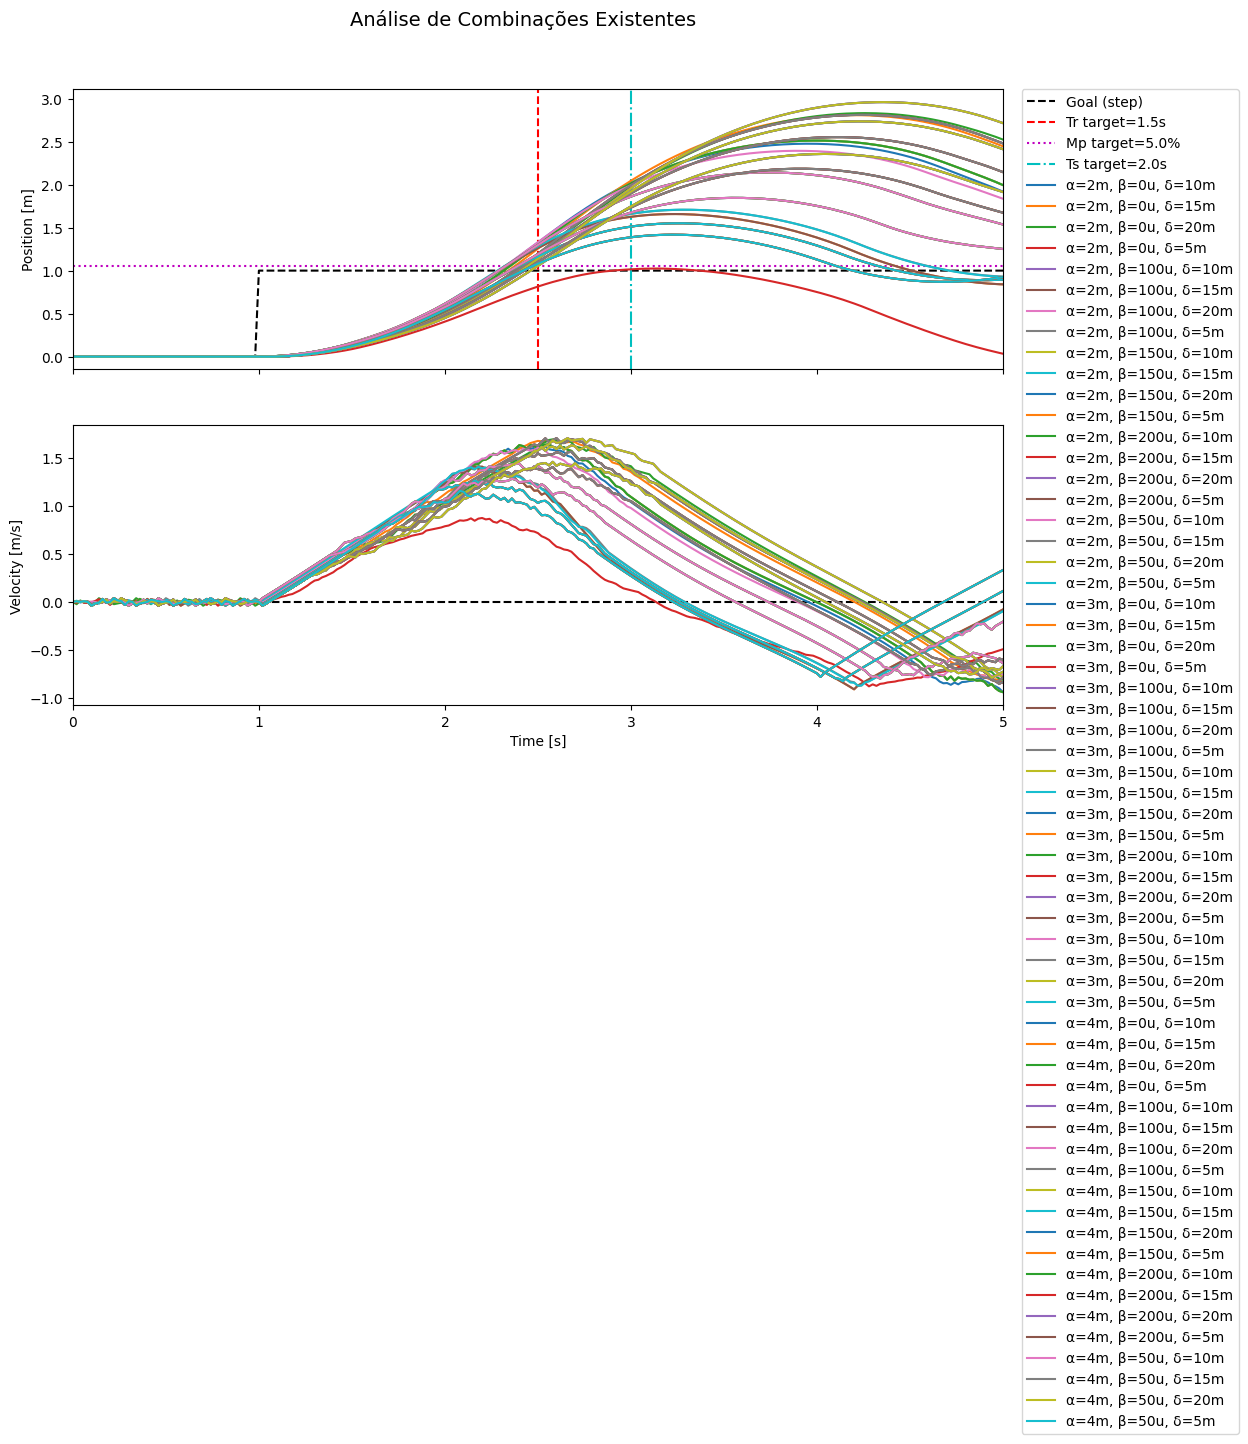

In [9]:
input_dir = r"C:\Supaero\Stage\Codigo3\Analysis\Data\Combination\Plot"

Data = []
L = []

# regex que captura A{valor}m_B{valor}u_D{valor}m_avg.csv
pattern = re.compile(r'^A(\d+)m_B(\d+)u_D(\d+)m_?Data_avg\.csv$', re.IGNORECASE)

for path in glob.glob(os.path.join(input_dir, "*_avg.csv")):
    fn = os.path.basename(path)
    m = pattern.match(fn)
    if not m:
        continue  # pula arquivos que não batam com o padrão
    a_val, b_val, d_val = m.groups()
    # monta o label com símbolos gregos e unidades
    label = f"α={a_val}m, β={b_val}u, δ={d_val}m"
    L.append(label)
    # lê o CSV e armazena
    sim = read_one(path)
    Data.append(sim)

# plota tudo de uma vez
Create_1D_Graphic(
    "Análise de Combinações Existentes",
    L,
    Data
)

# Analise dos 10 melhores #

In [11]:

# --- pasta onde estão os avg.csv ---
input_dir = r"C:\Supaero\Stage\Codigo3\Analysis\Data\Combination\Plot"

# regex para extrair o prefixo antes de "_avg.csv"
pattern = re.compile(r'^(.+)_avg\.csv$', re.IGNORECASE)

def compute_metrics(df, tol=0.05):
    """
    Detecta a coluna de tempo e de saída e retorna (Tr, Ts, Mp).
    tol é a banda de 5% para settling time.
    """
    # escolhe a coluna de tempo: procura 't' ou 'time' (case-insensitive), senão pega a 1ª
    cols = list(df.columns)
    time_col = next((c for c in cols if c.lower() in ('t','time')), cols[0])
    t = df[time_col].values

    # escolhe a coluna de saída: procura 'states','goals','pos', senão 2ª coluna numérica
    y_col = None
    for c in ('states','goals','pos'):
        if c in df.columns:
            y_col = c
            break
    if y_col is None:
        # pega a segunda coluna que seja numérica
        numeric_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
        y_col = numeric_cols[1] if len(numeric_cols)>1 else numeric_cols[0]
    y = df[y_col].values

    yf = y[-1]                 # valor final
    y10, y90 = 0.1*yf, 0.9*yf

    # Rise Time entre 10% e 90%
    try:
        t10 = t[np.where(y >= y10)[0][0]]
        t90 = t[np.where(y >= y90)[0][0]]
        Tr = t90 - t10
    except Exception:
        Tr = np.nan

    # Overshoot em %
    Mp = (np.max(y) - yf) / yf * 100.0

    # Settling Time: último ponto fora de ±tol*yf
    lower, upper = (1-tol)*yf, (1+tol)*yf
    idx_out = np.where((y < lower) | (y > upper))[0]
    Ts = t[idx_out[-1]] if idx_out.size else 0.0

    return Tr, Ts, Mp

# --- monta lista de resultados ---
records = []
for path in glob.glob(os.path.join(input_dir, "*_avg.csv")):
    fn = os.path.basename(path)
    m = pattern.match(fn)
    if not m:
        continue
    prefix = m.group(1)
    df = pd.read_csv(path)
    # DEBUG: descomente pra ver colunas
    # print(prefix, "columns:", df.columns.tolist())
    Tr, Ts, Mp = compute_metrics(df)
    records.append({'prefix': prefix, 'Tr(s)': Tr, 'Ts(s)': Ts, 'Mp(%)': Mp})

# cria DataFrame e ordena pelos melhores (menores) Ts, depois Tr e Mp
dfm = pd.DataFrame(records)
dfm_sorted = dfm.sort_values(by=['Ts(s)','Tr(s)','Mp(%)'], ascending=True)

# exibe top 10
print(dfm_sorted.head(10).to_string(index=False))


            prefix  Tr(s)  Ts(s)     Mp(%)
   A3m_B0u_D5mData   0.76   4.56 72.791086
 A3m_B100u_D5mData   0.76   4.56 72.791086
 A3m_B150u_D5mData   0.76   4.56 72.791086
 A3m_B200u_D5mData   0.76   4.56 72.791086
  A3m_B50u_D5mData   0.76   4.56 72.791086
  A4m_B0u_D10mData   1.00   4.76 48.087256
A4m_B100u_D10mData   1.00   4.76 48.087256
A4m_B150u_D10mData   1.00   4.76 48.087256
A4m_B200u_D10mData   1.00   4.76 48.087256
 A4m_B50u_D10mData   1.00   4.76 48.087256


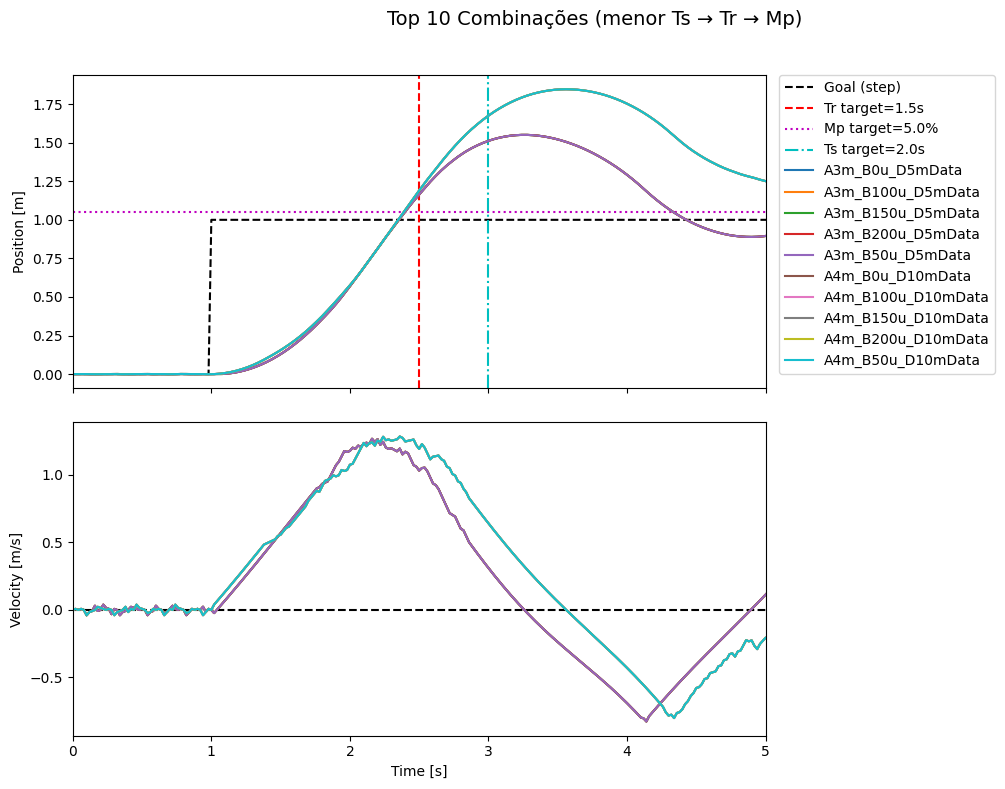

In [14]:
top10 = dfm_sorted.head(10)

# 4) Recarrega esses 10 para plotar
Data_top = []
L_top    = []
# regex para extrair os números do prefixo
rx = re.compile(r'^A(\d+)m_B(\d+)u_D(\d+)m$')
for prefix in top10['prefix']:
    csv_path = os.path.join(input_dir, f"{prefix}_avg.csv")
    sim = read_one(csv_path)
    Data_top.append(sim)
    m2 = rx.match(prefix)
    if m2:
        a, b, d = m2.groups()
        label = f"α={a}m, β={b}u, δ={d}m"
    else:
        label = prefix
    L_top.append(label)

# 5) Plota apenas os top 10
Create_1D_Graphic(
    "Top 10 Combinações (menor Ts → Tr → Mp)",
    L_top,
    Data_top
)

# Analise Variações de Alfa e Delta pra ver se melhora

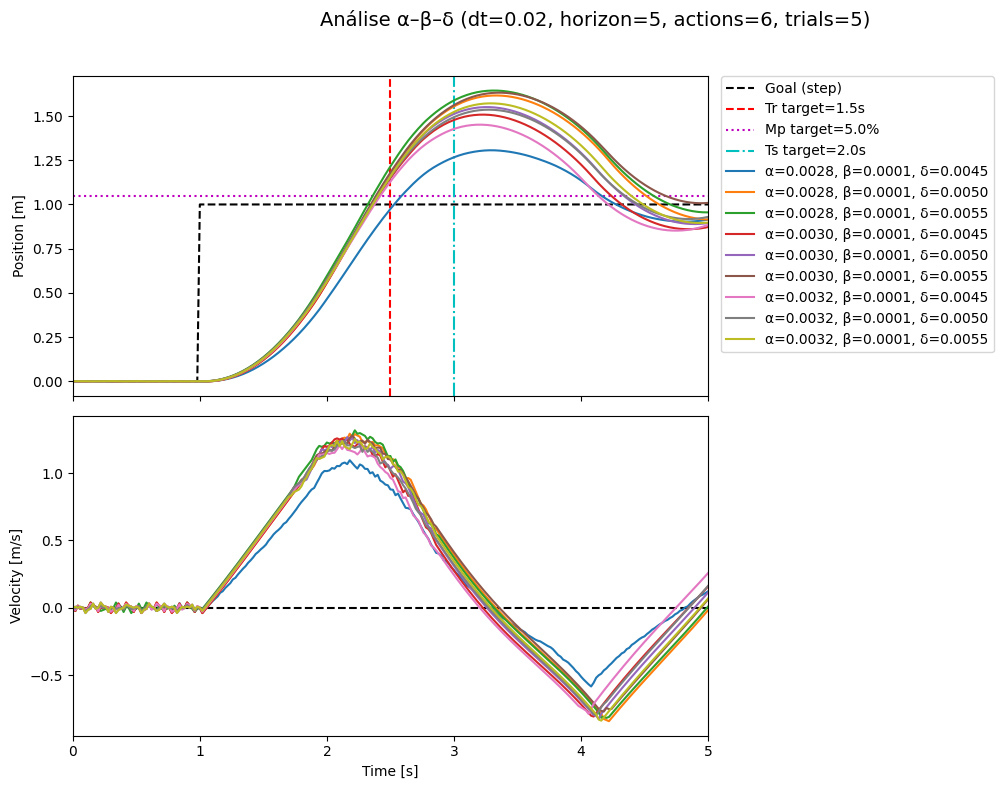

In [26]:
import numpy as np

Data      = []
subtitles = []

# Parâmetros do seu C++:
base_folder = 'Data/Complet/1'
alphas      = [0.0028, 0.0030, 0.0032]
beta_val    = 0.0001
deltas      = [0.0045, 0.0050, 0.0055]
trials      = 5  # conforme `const int trials = 5;`

for a in alphas:
    for d in deltas:
        # monta nome de subpasta igual ao seu ss.str():
        tag       = f"A{a:.4f}_B{beta_val:.4f}_D{d:.4f}"
        folder    = f"{base_folder}/{tag}"
        
        # lê os 5 dicts gerados pelo seu ModelR1
        trial_dicts = []
        for t in range(trials):
            path = f"{folder}/{tag}Data{t}.csv"
            trial_dicts.append(read_one(path))
        
        # constrói um dict médio, campo a campo
        avg_dict = {}
        for key in trial_dicts[0].keys():
            arrs = np.stack([dct[key] for dct in trial_dicts], axis=0)
            avg_dict[key] = np.mean(arrs, axis=0)
        
        Data.append(avg_dict)
        subtitles.append(f"α={a:.4f}, β={beta_val:.4f}, δ={d:.4f}")

# cria o gráfico com legendas completas
Create_1D_Graphic(
    "Análise α–β–δ (dt=0.02, horizon=5, actions=6, trials=5)",
    subtitles,
    Data
)

C:\Users\alexa\AppData\Local\Temp\ipykernel_17840\857613897.py:168: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 0.96])


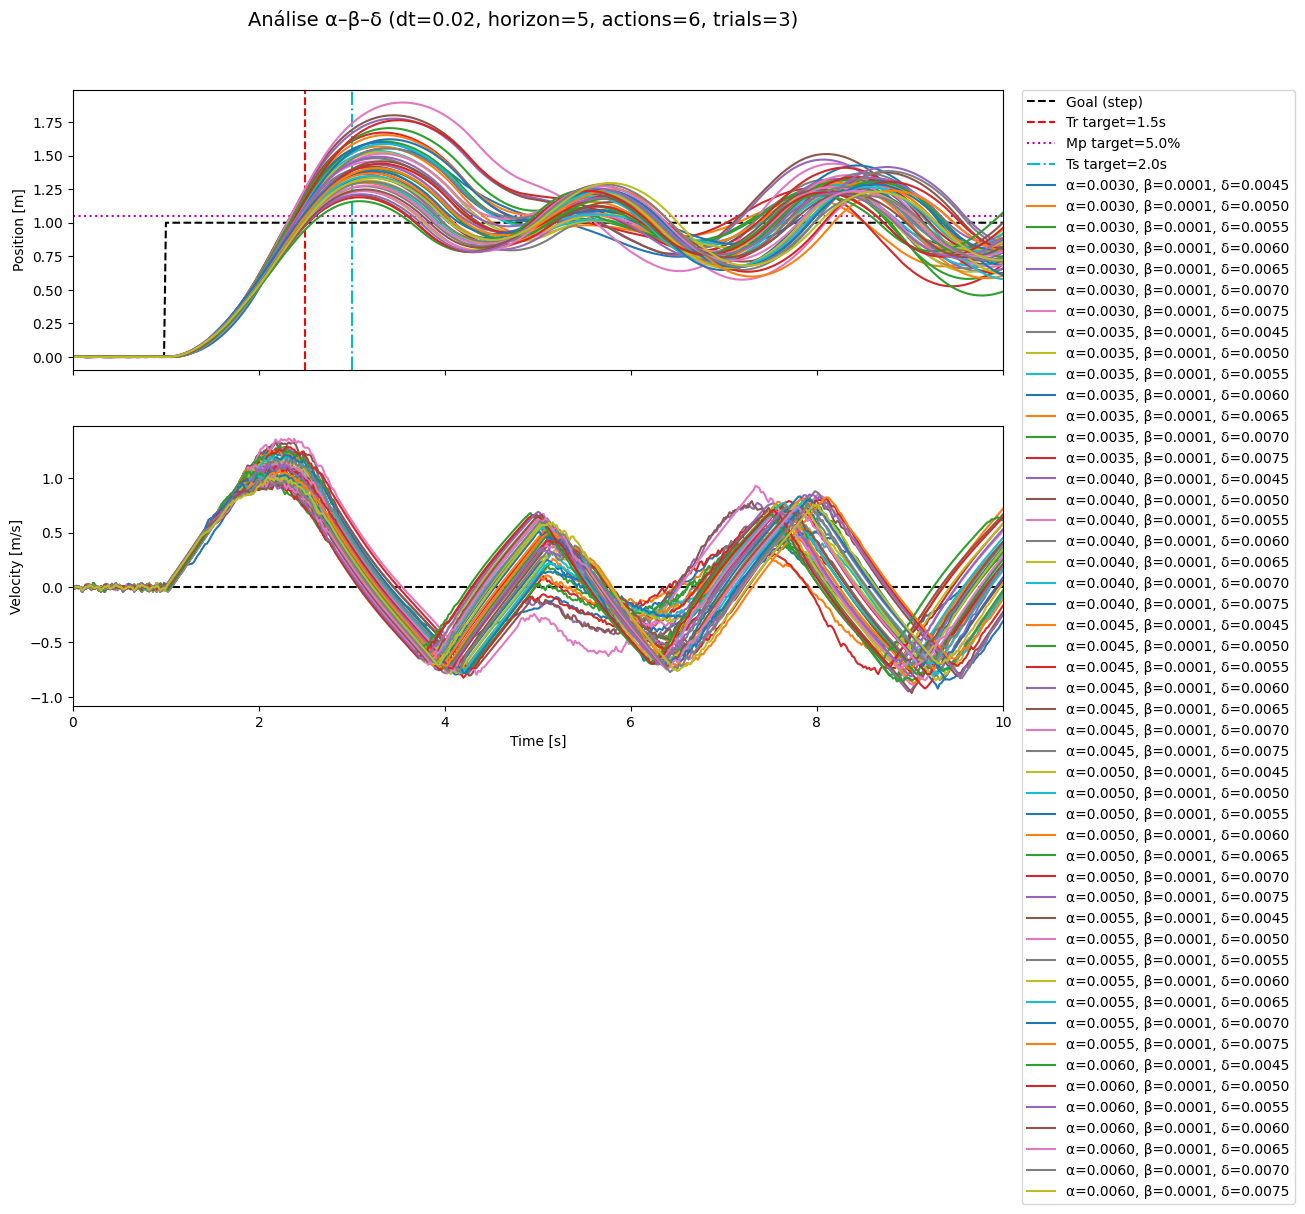

<Figure size 640x480 with 0 Axes>

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt

# supondo que read_one e Create_1D_Graphic já estejam no seu escopo

Data      = []
subtitles = []

# Parâmetros do seu C++:
base_folder = r"Data/Complet/2"
alphas      = [0.0030, 0.0035, 0.0040, 0.0045, 0.0050, 0.0055, 0.0060]
beta_val    = 0.0001
deltas      = [0.0045, 0.0050, 0.0055, 0.0060, 0.0065, 0.0070, 0.0075]
trials      = 3  # conforme const int trials = 3

for a in alphas:
    for d in deltas:
        tag = f"A{a:.4f}_B{beta_val:.4f}_D{d:.4f}"

        trial_dicts = []
        for t in range(trials):
            fname = f"{tag}Data{t}.csv"
            path  = os.path.join(base_folder, fname)
            if not os.path.isfile(path):
                print(f"[AVISO] não encontrou: {path}")
                continue
            trial_dicts.append(read_one(path))

        if not trial_dicts:
            continue

        avg_dict = {}
        for key in trial_dicts[0].keys():
            arrs = np.stack([dct[key] for dct in trial_dicts], axis=0)
            avg_dict[key] = np.mean(arrs, axis=0)

        Data.append(avg_dict)
        subtitles.append(f"α={a:.4f}, β={beta_val:.4f}, δ={d:.4f}")

# chama seu plot
Create_1D_Graphic(
    "Análise α–β–δ (dt=0.02, horizon=5, actions=6, trials=3)",
    subtitles,
    Data
)

# *** AQUI A PARTE NOVA: ***
# Ajusta TODOS os eixos da figura atual para irem de 0 a 10 segundos
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(0, 10)

# E ajusta as margens manualmente para caber a legenda/título
plt.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08)

plt.show()


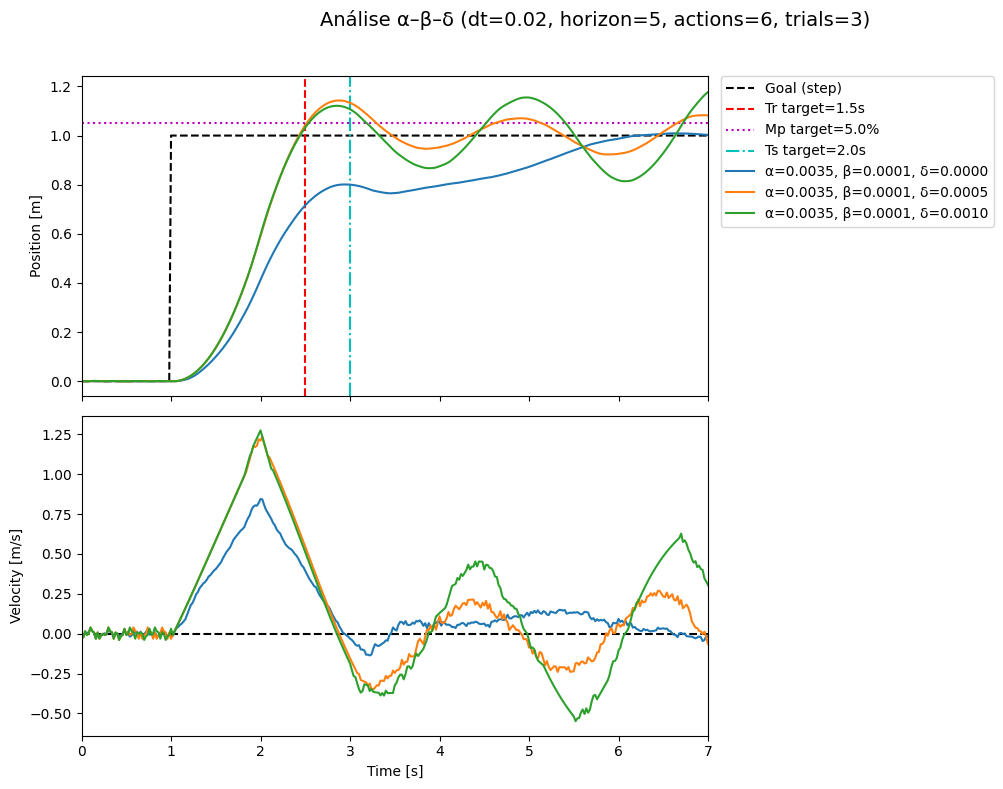

<Figure size 640x480 with 0 Axes>

In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt

# supondo que read_one e Create_1D_Graphic já estejam no seu escopo

Data      = []
subtitles = []

# Parâmetros do seu C++:
base_folder = r"Data/AlphaC/1"
alphas      = [0.0035]
beta_val    = 0.0001
deltas      = [0.0000, 0.0005, 0.0010]#, 0.0015,0.0020, 0.0025, 0.0030, 0.0035, 0.0040]
trials      = 3  # conforme const int trials = 3

for a in alphas:
    for d in deltas:
        tag = f"A{a:.4f}_B{beta_val:.4f}_D{d:.4f}"

        trial_dicts = []
        for t in range(trials):
            fname = f"{tag}Data_avg.csv"
            path  = os.path.join(base_folder, fname)
            if not os.path.isfile(path):
                print(f"[AVISO] não encontrou: {path}")
                continue
            trial_dicts.append(read_one(path))

        if not trial_dicts:
            continue

        avg_dict = {}
        for key in trial_dicts[0].keys():
            arrs = np.stack([dct[key] for dct in trial_dicts], axis=0)
            avg_dict[key] = np.mean(arrs, axis=0)

        Data.append(avg_dict)
        subtitles.append(f"α={a:.4f}, β={beta_val:.4f}, δ={d:.4f}")

# chama seu plot
Create_1D_Graphic(
    "Análise α–β–δ (dt=0.02, horizon=5, actions=6, trials=3)",
    subtitles,
    Data
)

# *** AQUI A PARTE NOVA: ***
# Ajusta TODOS os eixos da figura atual para irem de 0 a 10 segundos
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(0, 10)

# E ajusta as margens manualmente para caber a legenda/título
plt.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08)

plt.show()


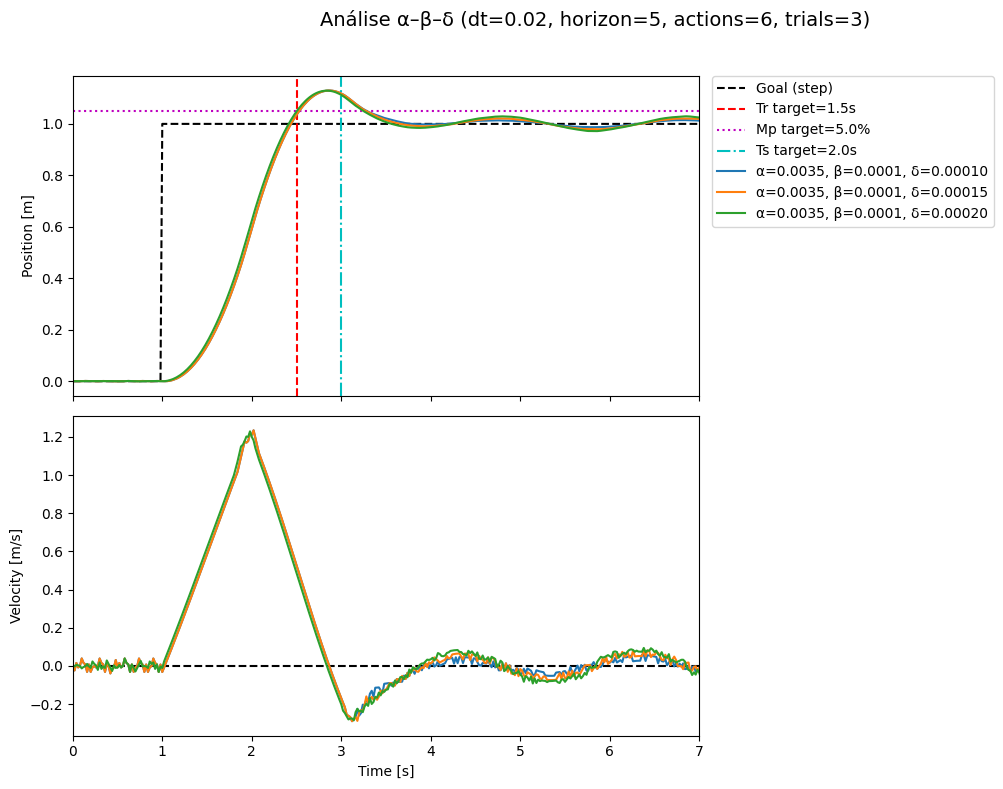

<Figure size 640x480 with 0 Axes>

In [69]:
# supondo que read_one e Create_1D_Graphic já estejam no seu escopo

Data      = []
subtitles = []

# Parâmetros do seu C++:
base_folder = r"Data/AlphaC/2"
alphas      = [0.0035]
beta_val    = 0.0001
deltas      = [0.00010, 0.00015, 0.00020]#,0.00025, 0.00030, 0.00035, 0.00040, 0.00045]
trials      = 3  # conforme const int trials = 3

for a in alphas:
    for d in deltas:
        tag   = f"D{d:.5f}"
        fname = f"{tag}Data_avg.csv"
        path  = os.path.join(base_folder, fname)
        if not os.path.isfile(path):
            print(f"[AVISO] não encontrou: {path}")
            continue

        avg_dict = read_one(path)
        Data.append(avg_dict)
        subtitles.append(f"α={a:.4f}, β={beta_val:.4f}, δ={d:.5f}")


# chama seu plot
Create_1D_Graphic(
    "Análise α–β–δ (dt=0.02, horizon=5, actions=6, trials=3)",
    subtitles,
    Data
)

# *** AQUI A PARTE NOVA: ***
# Ajusta TODOS os eixos da figura atual para irem de 0 a 10 segundos
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(0, 7)

# E ajusta as margens manualmente para caber a legenda/título
plt.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08)

plt.show()


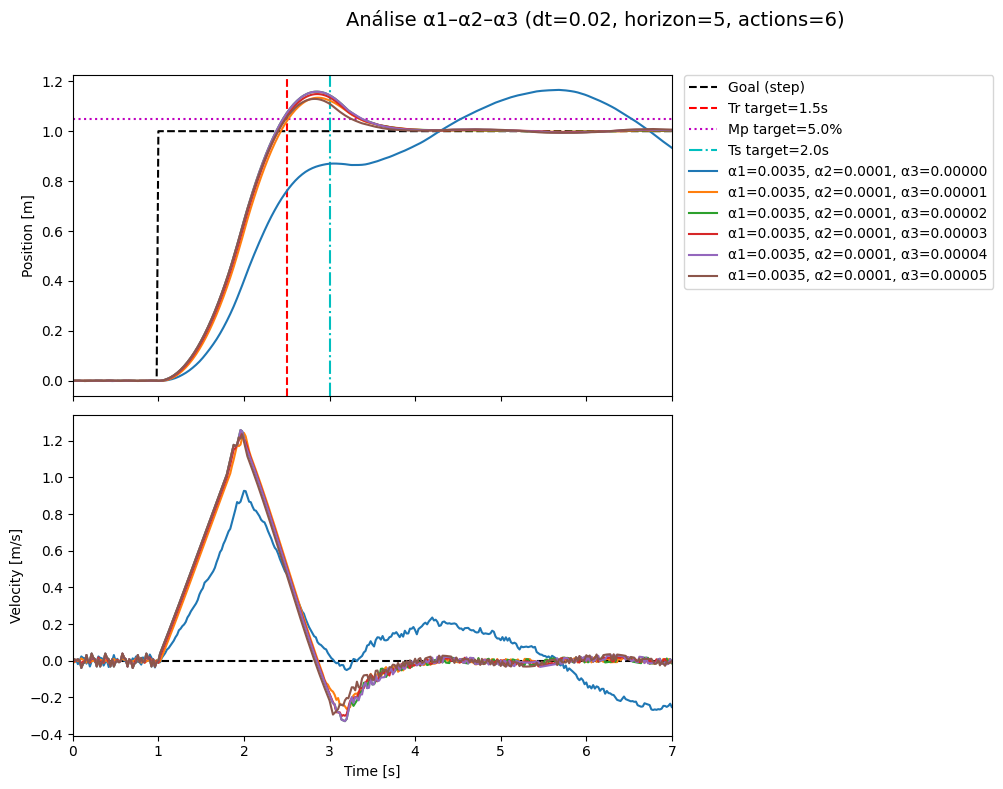

<Figure size 640x480 with 0 Axes>

In [4]:

Data      = []
subtitles = []

# Parâmetros do seu C++:
base_folder = r"Data/AlphaC/3"
alphas      = [0.0035]
beta_val    = 0.0001
deltas      = [0.00000, 0.00001, 0.00002, 0.00003, 0.00004, 0.00005]

for a in alphas:
    for d in deltas:
        # converte 0.00001 -> 1, 0.00002 -> 2, etc
        idx = int(round(d * 1e5))
        tag = f"D{idx}e-05"              # ex: D1e-05, D2e-05, …

        fname = f"{tag}Data_avg.csv"
        path  = os.path.join(base_folder, fname)
        if not os.path.isfile(path):
            print(f"[AVISO] não encontrou: {path}")
            continue

        avg_dict = read_one(path)
        Data.append(avg_dict)
        subtitles.append(f"α1={a:.4f}, α2={beta_val:.4f}, α3={d:.5f}")

# chama seu plot
Create_1D_Graphic(
    "Análise α1–α2–α3 (dt=0.02, horizon=5, actions=6)",
    subtitles,
    Data
)

# Ajusta eixos e margens
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(0, 7)
plt.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08)
plt.show()

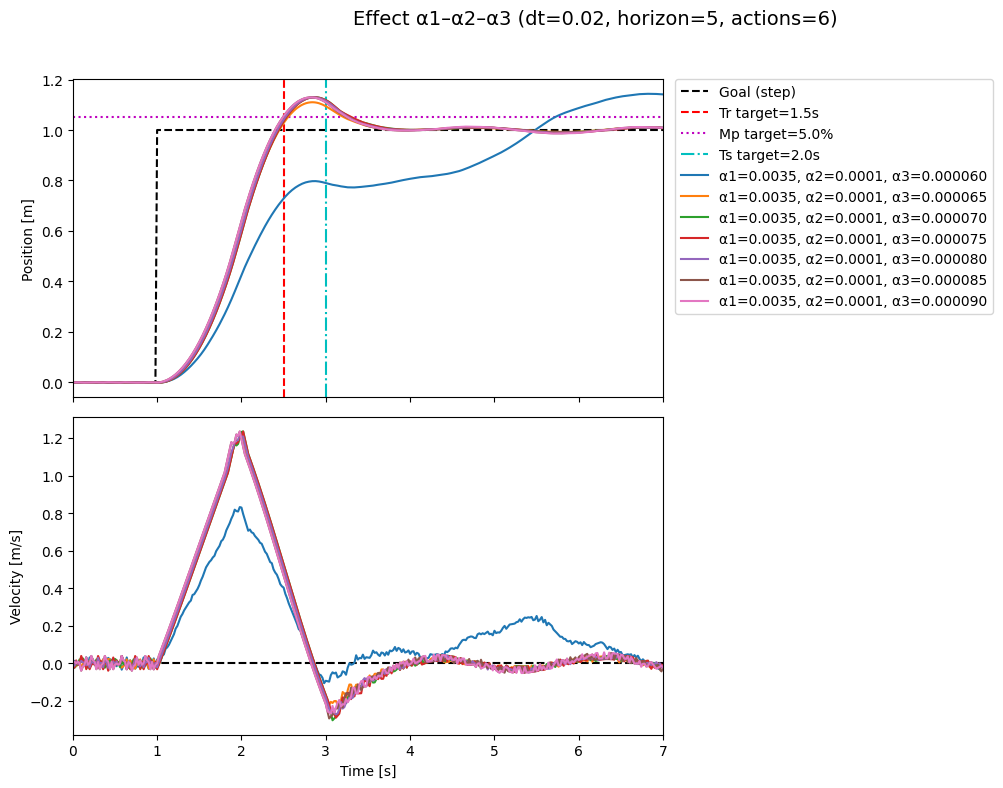

<Figure size 640x480 with 0 Axes>

In [5]:

Data      = []
subtitles = []

# Parâmetros do seu C++:
base_folder = r"Data/AlphaC/4"
alphas      = [0.0035]
beta_val    = 0.0001
deltas      = [0.00006, 0.000065, 0.00007, 0.000075, 0.00008, 0.000085, 0.00009]

for a in alphas:
    for d in deltas:
        # scientific notation com 1 casa decimal: 0.00006 -> "6.0e-05", 0.000065 -> "6.5e-05"
        d_str = format(d, ".1e")
        tag   = f"D{d_str}"
        fname = f"{tag}Data_avg.csv"
        path  = os.path.join(base_folder, fname)

        if not os.path.isfile(path):
            print(f"[AVISO] não encontrou: {path}")
            continue

        avg_dict = read_one(path)
        Data.append(avg_dict)
        subtitles.append(f"α1={a:.4f}, α2={beta_val:.4f}, α3={d:.6f}")

# chama seu plot
Create_1D_Graphic(
    "Effect α1–α2–α3 (dt=0.02, horizon=5, actions=6)",
    subtitles,
    Data
)

# Ajusta eixos e margens
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(0, 7)
plt.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08)
plt.show()

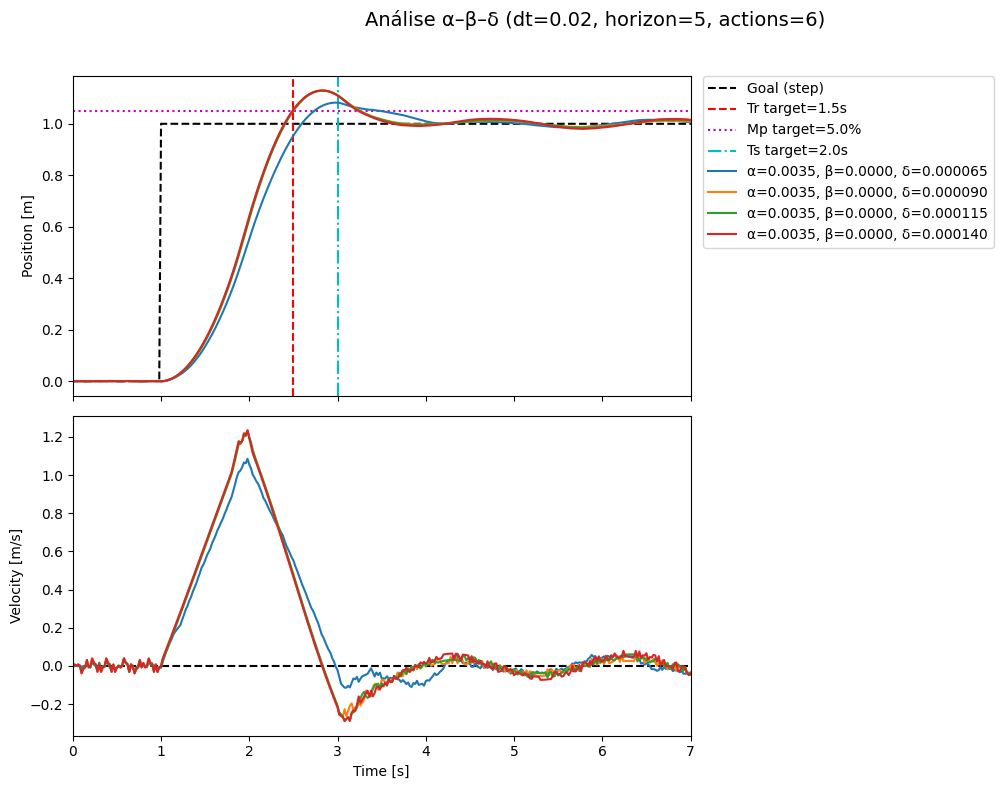

<Figure size 640x480 with 0 Axes>

In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt

# supondo que read_one e Create_1D_Graphic já estejam no seu escopo

Data      = []
subtitles = []

# Parâmetros do seu C++:
base_folder = r"Data/AlphaC/5"
alphas      = [0.0035]
beta_val    = 0.0
deltas      = [0.000065, 0.000090, 0.000115, 0.000140]
trials      = 5   # seu código usa trials = 5

for a in alphas:
    for d in deltas:
        # prefixo exatamente igual ao run_label do C++ ("Final" + d com 6 casas)
        tag = f"Final{d:.6f}"
        
        # lê cada trial Data0.csv … Data4.csv
        trial_dicts = []
        for t in range(trials):
            fname = f"{tag}Data{t}.csv"
            path  = os.path.join(base_folder, fname)
            if not os.path.isfile(path):
                print(f"[AVISO] não encontrou: {path}")
                continue
            trial_dicts.append(read_one(path))
        
        if not trial_dicts:
            continue
        
        # empilha e tira média ponto a ponto
        avg_dict = {}
        for key in trial_dicts[0].keys():
            arrs = np.stack([dct[key] for dct in trial_dicts], axis=0)
            avg_dict[key] = np.mean(arrs, axis=0)
        
        Data.append(avg_dict)
        subtitles.append(f"α={a:.4f}, β={beta_val:.4f}, δ={d:.6f}")

# se ficou vazio, algo ainda não bateu nos nomes
if not Data:
    raise RuntimeError("Nenhum arquivo foi lido — cheque os prefixos e a pasta.")

# chama seu plot já com todos os deltas varridos
Create_1D_Graphic(
    "Análise α–β–δ (dt=0.02, horizon=5, actions=6)",
    subtitles,
    Data
)

# Ajusta eixos e margens
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(0, 7)
plt.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08)
plt.show()


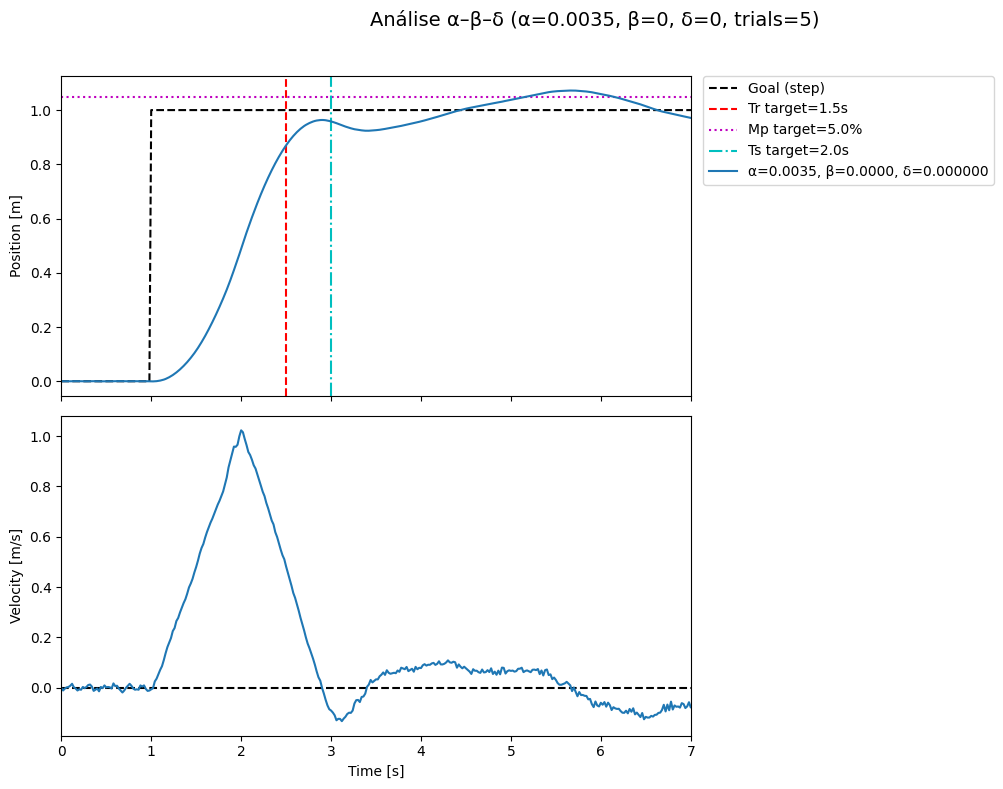

<Figure size 640x480 with 0 Axes>

In [86]:
Data      = []
subtitles = []

# Parâmetros do seu C++ / Python:
base_folder = r"Data/AlphaC/6"
alphas      = [0.0035]   # valor único de α
beta_val    = 0.0        # peso β fixo
delta_val   = 0.0        # peso δ fixo
trials      = 5          # número de trials

# Prefixo definido no C++:
tag = "Default"

for a in alphas:
    # lê cada trial DefaultData0.csv … DefaultData4.csv
    trial_dicts = []
    for t in range(trials):
        fname = f"{tag}Data{t}.csv"
        path  = os.path.join(base_folder, fname)
        if not os.path.isfile(path):
            print(f"[AVISO] não encontrou: {path}")
            continue
        trial_dicts.append(read_one(path))

    if not trial_dicts:
        raise RuntimeError("Nenhum arquivo lido — cheque o prefixo e a pasta.")

    # empilha e tira média ponto a ponto
    avg_dict = {}
    for key in trial_dicts[0].keys():
        arrs = np.stack([dct[key] for dct in trial_dicts], axis=0)
        avg_dict[key] = np.mean(arrs, axis=0)

    Data.append(avg_dict)
    subtitles.append(f"α={a:.4f}, β={beta_val:.4f}, δ={delta_val:.6f}")

# plota a única curva média
Create_1D_Graphic(
    "Análise α–β–δ (α=0.0035, β=0, δ=0, trials=5)",
    subtitles,
    Data
)

# Ajusta eixos e margens
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlim(0, 7)
plt.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08)
plt.show()